In [1]:
%matplotlib inline
import numpy as np
import fitsio as ft
import matplotlib.pyplot as plt
from   matplotlib.gridspec import GridSpec

import pandas as pd
import seaborn as sns
import pymangle
import healpy as hp
import sys
sys.path.append('../src')
from scipy.stats import pearsonr
from glob import glob
import plotting
import os
os.environ['PROJ_LIB'] = '/Users/rezaie/anaconda3/envs/py3p6/share/proj'

In [2]:
config = {'hpmap':{'frac':'/Volumes/TimeMachine/data/DR7/frac.hp.256.fits',
                   'ngal':'/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.cut.hp256.fits',
                   'ouname':'./figs/eboss-dr7.png',
                   'title':r'eBOSS ELG DECaLS DR7 density [deg$^{-2}$]',
                   'nside':256},
         'ccplot':{'frac':'/Volumes/TimeMachine/data/DR7/sysmaps/DECaLS_DR7/nside256_oversamp4/fracgood.hp.fits',
                   'ngal':'/Volumes/TimeMachine/data/DR7/eboss-ngc-dr7.1.cut.hp256.fits',
                   'feats':'/Volumes/TimeMachine/data/DR7/sysmaps/DECaLS_DR7/nside256_oversamp4/features.fits',
                  'ouname':'dr7_ccs.pdf',
                  'xticks':['ebv', 'nstar']+ [s+'-'+b for s in 
                                               ['depth', 'seeing', 'skymag','exptime', 'mjd'] for b in 'rgz'],
                  'label':'DR7 Data'},
          '2dclustering':{'cl_theory':'/Volumes/TimeMachine/data/mocks/fftlog.out',
                         'clpath':lambda l:'/Volumes/TimeMachine/data/DR7/results/clustering/cl_'+l+'.npy',
                         'xipath':lambda l:'/Volumes/TimeMachine/data/DR7/results/clustering/xi_'+l+'_nside_256_njack_0.npy',
                         'title':'DR7 DATA',
                          #'lb':['with linear weights','with quadratic weights','no weights', 
                          #        'with NN weights (spatial)','with NN weights', 'with NN weights w/ ablation'],
                          #'flb':['lin', 'quad', 'uni', 'nns-10', 'nnr-10', 'nnrab-10'],
                          'lb':['no weights', 'with linear weights','with quadratic weights', 'with NN weights'],
                          'flb':['uni','lin', 'quad', 'nn_ab'],                          
                         'ouname':'dr7_clustering.pdf'},
         'corrmax':{'feats':'/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.table.fits',
                     'xticks':['EBV', 'logHI', 'nstar']+ [s+'-'+b for s in 
                               ['depth', 'seeing', 'skymag','exptime', 'mjd'] for b in 'rgz'],
                   'ouname':'./figs/corrmax-dr7.pdf'},
          'nnbarplot':{'nnbarpath':lambda l:'/Volumes/TimeMachine/data/DR7/results/clustering/nnbar_'+l+'.npy',
                         'title':'DR7 DATA',
                          #'lb':['with linear weights','with quadratic weights','no weights', 
                          #       'with NN weights (spatial)','with NN weights', 'with NN weights w/ ablation'],
                          #'flb':['lin', 'quad', 'uni', 'nns-10', 'nnr-10', 'nnrab-10'],
                          'lb':['no weights', 'with linear weights','with quadratic weights', 'with NN weights'],
                          'flb':['uni','lin', 'quad', 'nn_ab'],                          
                         'ouname':'dr7_nnbar.pdf'},
          'mocks_ablation':{'uncont.':'/Volumes/TimeMachine/data/mocks/3dbox/*/ablation/r/*.log.npy',
                            'cont.':'/Volumes/TimeMachine/data/mocks/3dbox/*/c4n/ablation/r/*.log.npy',
                            'xticks':['ebv', 'nstar']+[s+'-'+b for s in ['depth', 'seeing', 'airmass',
                                                                         'skymag', 'exptime'] for b in 'rgz'],
                           'title':'DR5 Mocks',
                           'ouname':'./mocks_ablation.pdf'},
        'crosscl':{
             'clpath':lambda l:'/Volumes/TimeMachine/data/DR7/results/clustering/cl_'+l+'.npy',
             'clsys':'/Volumes/TimeMachine/data/DR7/results/clustering/cl_sys.npy',
             'xipath':lambda l:'/Volumes/TimeMachine/data/DR7/results/clustering/xi_'+l+'_nside_256_njack_0.npy',
             'title':'DR7 DATA',
              #'lb':['with linear weights','with quadratic weights','no weights', 
              #        'with NN weights (spatial)','with NN weights', 'with NN weights w/ ablation'],
              #'flb':['lin', 'quad', 'uni', 'nns-10', 'nnr-10', 'nnrab-10'],
              'lb':['no weights', 'with linear weights','with quadratic weights', 'with NN weights'],
              'flb':['uni','lin', 'quad', 'nn_ab'],                          
             'ouname':'dr7_crosscl.pdf',
              'xticks':['ebv', 'logHI', 'nstar']+ [s+'-'+b for s in 
                       ['depth', 'seeing', 'skymag','exptime', 'mjd'] for b in 'rgz']}
         }

Multipoles HEALPIX

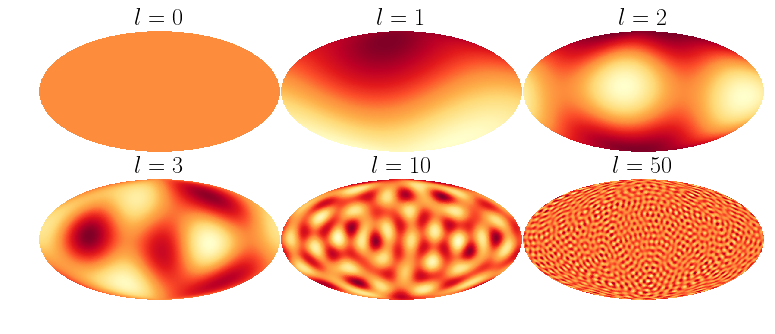

In [86]:
def plot_multipoles():
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 20,
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'text.usetex': True,
   #'figure.figsize': [6, 4],
   'font.family':'serif',
    'font.size':20
   }
    cmap = plt.cm.YlOrRd_r
    cmap.set_under('w')
    plt.rcParams.update(params)
#     plt.rc('font', family='serif', size=15)
    np.random.seed(12345)
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(13, 5))
    plt.subplots_adjust(wspace=0., hspace=0.2)
    ax      = ax.flatten()
    for il,l in enumerate([0, 1, 2, 3, 10, 50]):    
        cl    = np.zeros(12*128*128)
        cl[l] = 1
        map1  = hp.synfast(cl, 128, pol=False, new=True, verbose=False)
        plt.sca(ax[il])
        hp.mollview(map1, cbar=False, notext=True, title=r'$l=%d$'%l, hold=True, cmap=cmap) #cmap.set_under('w')
    plt.savefig('./figs/multipoles.pdf', bbox_inches='tight')
plot_multipoles()

## Correlation matrix of DR7 metadata

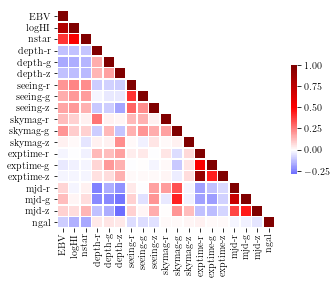

In [92]:
def plot_corrmax(config):
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 12,
   #'text.fontsize': 8,
   'legend.fontsize': 12,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': True,
   #'figure.figsize': [6, 4],
   'font.family':'serif'
   }
    plt.rcParams.update(params)
    data, h = ft.read(config['corrmax']['feats'], header=True)
    labels = config['corrmax']['xticks']
    mat = np.column_stack([data['features'].byteswap().newbyteorder(),
                           data['label'].byteswap().newbyteorder()])
    d = pd.DataFrame(data=mat, columns=labels+['ngal'])
    corr_cf = d.corr()
    mask = np.ones_like(corr_cf, dtype=np.bool)
    mask[np.tril_indices_from(mask)] = False
    f, ax = plt.subplots(figsize=(6, 4))
    kw = dict(mask=mask, cmap=plt.cm.seismic, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    sns.heatmap(corr_cf, **kw)
    plt.savefig(config['corrmax']['ouname'], bbox_inches='tight')
plot_corrmax(config)

## DR7 eBOSS-like ELG Density map

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


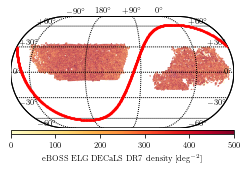

In [5]:
# density map
def plot_elghmap(config):
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 8,
   #'text.fontsize': 8,
   'legend.fontsize': 8,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':8
   }
    plt.rcParams.update(params)    
    frac = hp.read_map(config['hpmap']['frac'], verbose=False)
    ngal = hp.read_map(config['hpmap']['ngal'], verbose=False)
    #plt.rc('font', family='serif', size=15)
    plt.figure(figsize=(4, 3))
    plotting.plot_healpix_map(ngal/frac/hp.nside2pixarea(config['hpmap']['nside'], degrees=True), 
                              label=config['hpmap']['title'],
                              vlimits=[0, 500], cmap='YlOrRd')
    plt.savefig(config['hpmap']['ouname'], bbox_inches='tight', dpi=300)
    
# plot density map    
plot_elghmap(config)

## Ablation


save ...  ./figs/dr7.pdf


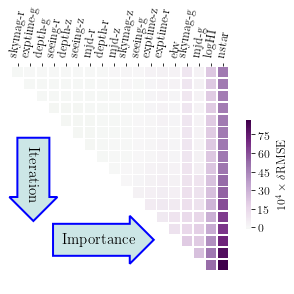

In [33]:
def ablation_plot(filename, odir):    
    params = {
    'axes.spines.right':False,
    'axes.spines.top':False,
    'axes.labelsize': 12,
    #'text.fontsize': 8,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'figure.figsize': [6, 4], # 11 9
    'font.family':'serif'}
    plt.rcParams.update(params)
    ab1 = np.load(filename).item()
    #
    INDICES = ab1['indices']
    VALUES  = ab1['validmin']
    FEAT    = ab1['importance'] + [i for i in range(18)\
                  if i not in ab1['importance']]

    matric_dict = {}
    for i in range(len(INDICES)):
        for j in range(len(VALUES[i])):
            matric_dict[str(i)+'-'+str(INDICES[i][j])] = VALUES[i][j]

    matric = np.zeros(shape=(18, 18))
    for i in range(17):
        for j, sys_i in enumerate(FEAT):
            if str(i)+'-'+str(sys_i) in matric_dict.keys():
                matric[i,j] = (matric_dict['%d-%d'%(i,sys_i)][0]/ab1['RMSEall'])-1.#-ab1['baselineRMSE']
    matric *= 1.e4
    bands = ['r','g','z']
    labels = ['ebv','logHI','nstar']
    labels += ['depth-'+b for b in bands]
    labels += ['seeing-'+b for b in bands]
    #labels += ['airmass-'+b for b in bands]
    labels += ['skymag-'+b for b in bands]
    labels += ['exptime-'+b for b in bands]
    labels += ['mjd-'+b for b in bands]
    xlabels = [labels[j] for j in FEAT]
    mask = ~np.zeros_like(matric, dtype=np.bool)
    #mask[np.triu_indices_from(mask)] = False
    mask[matric==0.0] = False
    vmin = np.minimum(np.abs(np.min(matric)), np.abs(np.max(matric))) #* 0.1
    # Set up the matplotlib figure
    f, ax = plt.subplots()
    #plt.title('Correlation Matrix of DR5')
    # Generate a custom diverging colormap
    kw = dict(mask=~mask, cmap=plt.cm.PRGn_r, xticklabels=xlabels,
               yticklabels=xlabels[::-1], 
               center=0.0, #vmax=50, #vmin=-1.*vmin, vmax=vmin, 
               square=True, linewidths=.5, 
               cbar_kws={"shrink": .5, 
               "label":r'$10^{4} \times \delta$RMSE'})
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(matric, **kw)
    ax.set_xticklabels(xlabels, rotation=80)
    ax.set_yticks([])
    ax.xaxis.tick_top()
    bbox_props = dict(boxstyle="rarrow", fc=(0.8, 0.9, 0.9), ec="b", lw=2)
    t = ax.text(0.4, 0.2, "Importance",
                ha="center", va="center", rotation=0,
                transform=ax.transAxes,
                bbox=bbox_props, fontsize=15)
    bb = t.get_bbox_patch()
    bb.set_boxstyle("rarrow", pad=0.6)
    t1 = ax.text(0.1, 0.5, "Iteration",
                ha="center", va="center", rotation=-90,
                transform=ax.transAxes,
                bbox=bbox_props, fontsize=15)
    bb1 = t1.get_bbox_patch()
    bb1.set_boxstyle("rarrow", pad=0.6)
    fname = filename.split('/')[-1][:-8]  # drop .log.npy
    #ou = ''.join([filename[:-4], '.pdf']) # drop .npy
    ou = ''.join([odir, fname, '.pdf'])
    print('save ... ', ou)
    plt.savefig(ou, bbox_inches='tight')


ablation_plot('/Volumes/TimeMachine/data/DR7/results/ablation/dr7.log.npy','./figs/')

## Selection masks

camb is not installed!


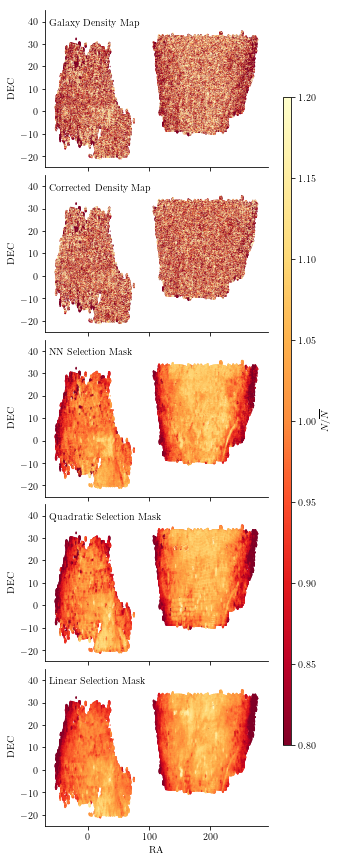

In [4]:
def ngal_selection_masks():   
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 10,
   #'text.fontsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':10
   }
    plt.rcParams.update(params)        
    from utils import makedelta, hpix2radec
    galmap = hp.read_map('/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.cut.hp256.fits', verbose=False)
    wnn    = hp.read_map('/Volumes/TimeMachine/data/DR7/results/regression/nn_ab/nn-weights.hp256.fits', verbose=False)
    wlin   = hp.read_map('/Volumes/TimeMachine/data/DR7/results/regression/mult_all/lin-weights.hp256.fits', verbose=False)
    wqud   = hp.read_map('/Volumes/TimeMachine/data/DR7/results/regression/mult_all/quad-weights.hp256.fits', verbose=False)
    mask   = hp.read_map('/Volumes/TimeMachine/data/DR7/mask.hp.256.fits', verbose=False).astype('bool')
    frac   = hp.read_map('/Volumes/TimeMachine/data/DR7/frac.hp.256.fits', verbose=False)
    # smooth the NN weights
    #wnnmean = np.mean(wnn[mask])
    #print(wnnmean)
    #wnn[~mask] = wnnmean
    #print(np.mean(galmap[mask]))
    #sdeg = np.deg2rad(0.25)
    #wnn = hp.smoothing(wnn.copy(), sigma=sdeg)
    #
    dnn   = makedelta(galmap, frac, mask, wnn) + 1.0
    # dlin = makedelta(galmap, frac, mask, wlin)
    # duni = makedelta(galmap, frac, mask)
    nnbar = makedelta(galmap, frac, mask) + 1.0

    plt.rc('axes.spines', top=False, right=False)
    plt.rc('font', family='serif')
    plt.rc('text', usetex=True)
    hpix = np.argwhere(mask).flatten()
    fig, ax = plt.subplots(nrows=5, figsize=(4, 15), sharex=True)
    plt.subplots_adjust(hspace=0.05)

    #ttl = ['No weights', 'Linear weights', 'NN weights']
    ttl = ['Galaxy Density Map', 'Corrected Density Map', 
           'NN Selection Mask', 'Quadratic Selection Mask', 
           'Linear Selection Mask']
    
    #for i,di in enumerate([duni, dlin, dnn]):
    radec = hpix2radec(256, hpix)
    ramm  = radec[0] > 300
    radec[0][ramm] -= 360.    
    for i,di in enumerate([nnbar, dnn, wnn, wqud, wlin]):
        map1 = ax[i].scatter(radec[0], radec[1], 0.1, 
                             #c=5*di[mask], vmin=-1, vmax=1.,
                            c=di[mask], vmin=0.8, vmax=1.2,
                            cmap=plt.cm.YlOrRd_r)
        ax[i].text(0.02, 0.9, ttl[i], transform=ax[i].transAxes)
        ax[i].set_ylim(-25, 45)
        ax[4].set_xlabel('RA')
        ax[i].set_ylabel('DEC')
        #ax[i].axis([200, 310, 0, 20])
    cax = plt.axes([.95, 0.2, 0.03, 0.6])
    #fig.colorbar(map1, cax=cax)
    fig.colorbar(map1, cax=cax, label=r'$N/\overline{N}$', shrink=0.7)
    plt.savefig('./figs/deltas.png', bbox_inches='tight', dpi=300)
ngal_selection_masks()

-0.7187392734140989 6.016243228203964
-0.17907491193096892 1.658631353936358
-0.10337270229297879 1.4132270173432537
0.004298904713842473


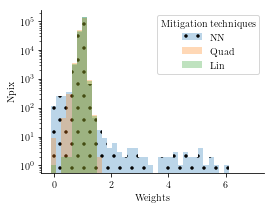

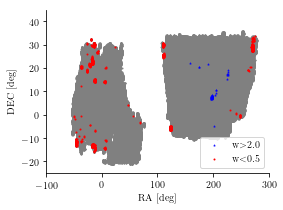

In [9]:
def selection_masks_hists():
    from utils import makedelta, hpix2radec
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 10,
   #'text.fontsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': True,
   'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':10
   }
    plt.rcParams.update(params)            
    wnn    = hp.read_map('/Volumes/TimeMachine/data/DR7/results/regression/nn_ab/nn-weights.hp256.fits', verbose=False)
    wlin   = hp.read_map('/Volumes/TimeMachine/data/DR7/results/regression/mult_all/lin-weights.hp256.fits', verbose=False)
    wqud   = hp.read_map('/Volumes/TimeMachine/data/DR7/results/regression/mult_all/quad-weights.hp256.fits', verbose=False)
    mask   = hp.read_map('/Volumes/TimeMachine/data/DR7/mask.hp.256.fits', verbose=False).astype('bool')
    frac   = hp.read_map('/Volumes/TimeMachine/data/DR7/frac.hp.256.fits', verbose=False)    
    #
    #
    h = ['.', None, None]
    lb= ['NN', 'Quad', 'Lin'] 
    i = 0
    plt.figure()
    for sm in [wnn, wqud, wlin]:
        print(sm[mask].min(), sm[mask].max())
        plt.hist(sm[mask], bins=40, range=(-0.1, 7.0),
                 alpha=0.3, hatch=h[i], label=lb[i])
        i +=1
    plt.legend(title='Mitigation techniques')
    plt.xlabel('Weights')
    plt.ylabel('Npix')
    plt.yscale('log')
    plt.savefig('./figs/w_dr7.pdf', bbox_inches='tight')
    #
    #
    #
    
    gt2   = wnn[mask] > 2.0
    ltp5  = wnn[mask] < 0.5
    hpix  = np.argwhere(mask).flatten()
    radec = hpix2radec(256, hpix)
    ramm  = radec[0] > 300
    radec[0][ramm] -= 360. 
    print((gt2 | ltp5).sum()/mask.sum())
    #
    #
    plt.figure()
    plt.scatter(radec[0], radec[1], 1.0, color='grey')
    plt.scatter(radec[0][gt2],  radec[1][gt2],   1.0,  color='b', label=r'w$>$2.0', marker='^')
    plt.scatter(radec[0][ltp5], radec[1][ltp5],  1.0,  color='r', label=r'w$<$0.5', marker='o')
    plt.ylim(-25, 45)
    plt.xlim(-100, 300)
    plt.xlabel('RA  [deg]')
    plt.ylabel('DEC [deg]')
    plt.legend()
    plt.savefig('./figs/w_dr7_extremes.png', bbox_inches='tight', dpi=300)
    
selection_masks_hists()

## MOCKS

camb is not installed!


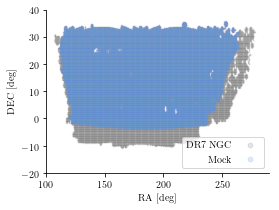

In [3]:
def plot_mock_on_dr(maskm, maskd):
    from utils import hpix2radec
    params = {
    'axes.spines.right':False,
    'axes.spines.top':False,
    'axes.labelsize': 10,
    #'text.fontsize': 8,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': True,
    'figure.figsize': [4, 3],
    'font.family':'serif',
    'font.size':10
    }
    plt.rcParams.update(params)            


    mockm  = hp.read_map(maskm, verbose=False).astype('bool')
    mockd  = hp.read_map(maskd, verbose=False).astype('bool')
    radecm = hpix2radec(256, np.argwhere(mockm).flatten())
    radecd = hpix2radec(256, np.argwhere(mockd).flatten())
    ramm   = radecd[0] > 300
    radecd[0][ramm] -= 360. 


    plt.figure()
    plt.scatter(*radecd, 0.1, marker='o', color='grey',    label='DR7 NGC', alpha=0.2)
    plt.scatter(*radecm, 0.1, marker='o', color='cornflowerblue', label='Mock',    alpha=0.2)
    plt.axis([100., 290., -20., 40.])
    plt.legend(markerscale=15, markerfirst=False)
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.savefig('./figs/mockondr.png', bbox_inches='tight', dpi=300)
    #
maskm = '/Volumes/TimeMachine/data/mocks/mask.hp.256.fits'
maskd = '/Volumes/TimeMachine/data/DR7/mask.hp.256.fits'
plot_mock_on_dr(maskm, maskd)

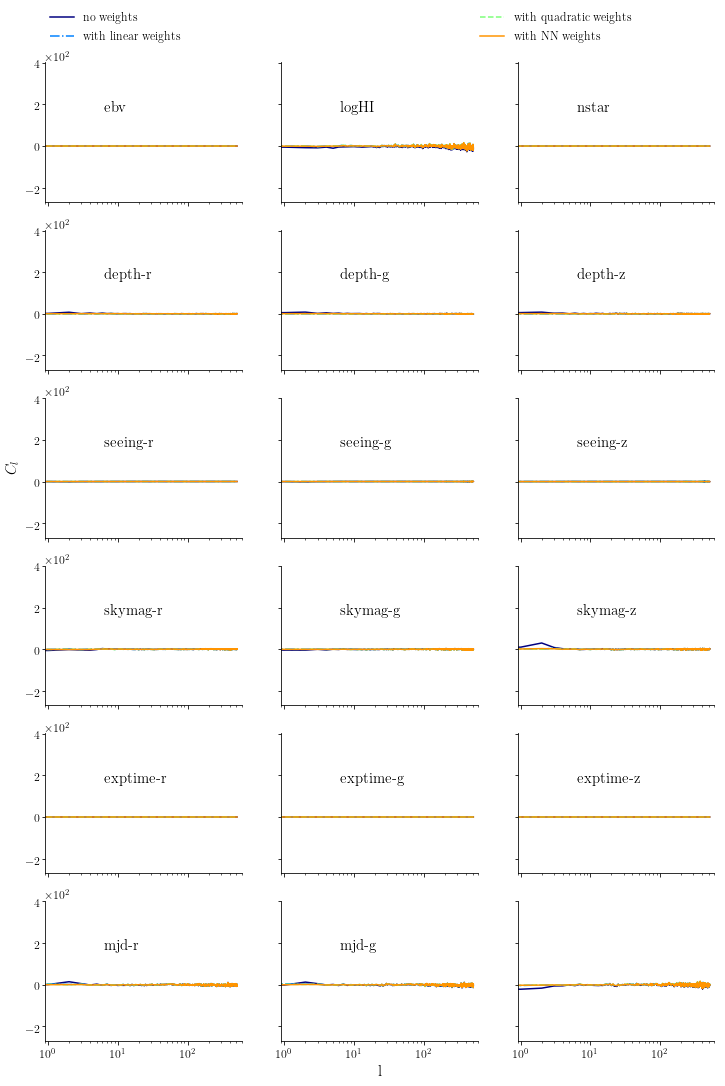

In [8]:
def plot_cl_cross_dr(config):
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 15,
   #'text.fontsize': 8,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':12
   }
    plt.rcParams.update(params)
    #plt.rc('xtick', labelsize='medium')
    #plt.rc('ytick', labelsize='medium')
    ND = len(config['crosscl']['flb'])
    c  = plt.cm.jet
    ls = 5*['-','-.','--', '-']
    pltarg = dict(ncols=3, nrows=6, sharex=True, figsize=(3*4, 6*3), sharey=True)
    tckfmt = dict(style='sci', axis='y', scilimits=(0,0))
#     lgnarg = dict(bbox_to_anchor=(1.1, 0.9), frameon=False, ncol=1, 
#                   title=config['crosscl']['title'], fontsize=15)
    lgnarg = dict(ncol=2,frameon=False,
                 bbox_to_anchor=(0, 1.1, 3, 0.4), loc="lower left",
                mode="expand", borderaxespad=0)        
    xlim   = (.9, 600)
    ylim   = (-1.2, 1.2)
    clsys  = np.load(config['crosscl']['clsys']).item()
    #
    #  PLOT
    #
    def add_plot(fs, a, color='b', label='none', ls='-', clsys=clsys):    
        d = np.load(fs).item()
        for i in range(d['cross'].shape[0]):
            l = np.arange(d['cross'][i, :].size)
            cl= d['cross'][i, :] / clsys['cross'][i, :]
            a[i].plot(l, cl, color=color, label=label, linestyle=ls)

    f,a    = plt.subplots(**pltarg)
    # plt.subplots_adjust(hspace=0.0, wspace=0.0)
    a = a.flatten()
    for i, fi in enumerate(config['crosscl']['flb']):
        add_plot(config['crosscl']['clpath'](fi), a, c(i/ND), config['crosscl']['lb'][i], ls[i])
    for i in range(len(a)):
        if i ==6:a[i].set_ylabel(r'$C_l$')
        if i ==16:a[i].set_xlabel('l')
        if i<17:a[i].text(0.3,0.65, r'%s'\
                          %config['crosscl']['xticks'][i], transform=a[i].transAxes, fontsize=15)
        a[i].ticklabel_format(**tckfmt)
        a[i].tick_params(axis='y', pad=1.0)
        a[i].set_xscale('log')
        a[i].set_xlim(*xlim)
        #ax[i].set_ylim(*ylim)        
    a[0].legend(**lgnarg)
    #f.delaxes(a[17])

    plt.savefig(config['crosscl']['ouname'], bbox_inches='tight')
plot_cl_cross_dr(config)

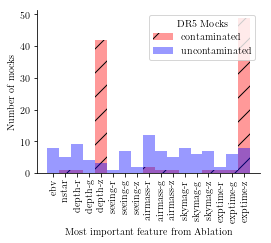

In [8]:
def plot_ablation(config):
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 10,
   #'text.fontsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':10
   }
    plt.rcParams.update(params)
    
    ND = len(config['mocks_ablation']['xticks'])
    f, a = plt.subplots(figsize=(4, 3))
    a.set_xticklabels(config['mocks_ablation']['xticks'], rotation=90)
    a.set_xticks(np.arange(ND))
    def get_important(filed):
        files = glob(filed)
        important = []
        for uli in files:
            d = np.load(uli).item()
            im = np.setdiff1d(np.arange(ND), d['importance'])[0]
            #if im not in [4, 16]:print(uli)
            important.append(im)
            #important.append(d['importance'][-1])
        return important

    imu = get_important(config['mocks_ablation']['uncont.'])
    imc = get_important(config['mocks_ablation']['cont.'])
    kw = dict(bins=np.arange(0, ND+1, 1), align='left', alpha=0.4)
    a.hist(imc, color='r', label='contaminated', **kw, hatch='/')
    a.hist(imu, color='b', label='uncontaminated', **kw)
    a.set_xlabel('Most important feature from Ablation')
    a.set_ylabel('Number of mocks')
    a.legend(title=config['mocks_ablation']['title'])
    plt.savefig(config['mocks_ablation']['ouname'], bbox_inches='tight')
plot_ablation(config)

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


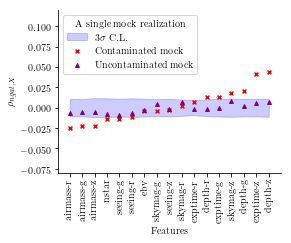

In [27]:
def plot_cf(config):
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 10,
   #'text.fontsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':10
   }
    plt.rcParams.update(params)    
    def get_cf(l, fs):
        cf = []
        for i in range(fs.shape[1]):
            cf.append(pearsonr(l, fs[:, i])[0])
        return np.array(cf)
    def bootstrap(l, fs, n=100):
        CF = []
        for i in range(n):
            #if i % 100==0:print(i)
            lb = np.random.permutation(l)
            CF.append(get_cf(lb, fs))
        return np.array(CF)

    def cfs(ls, cf, CF, ou='./dr7_ccs.pdf', cf2=None, lbs=['DR7'], ylim=(-0.2, 0.2)):
        nsys = CF.shape[1]
        D = np.zeros(nsys, dtype=np.dtype([('cf', 'f8'), ('lb', 'i'), ('std', 'f8'), ('cf2', 'f8')]))
        x = np.arange(nsys)
        D['lb'] = x
        D['cf'] = cf
        if cf2 is not None:D['cf2'] = cf2
        D['std']= np.std(CF, axis=0)
        Ds = np.sort(D, order='cf')
        lss = [ls[i] for i in Ds['lb']]


        f,a=plt.subplots(figsize=(4,3))
        a.fill_between(x, -3*Ds['std'], 3*Ds['std'], alpha=0.2,
                       color='blue', label=r'3$\sigma$ C.L.')
        a.scatter(x, Ds['cf'], s=15, c='r', label=lbs[0], marker='x')
        if cf2 is not None:
            a.scatter(x, Ds['cf2'], s=15, c='purple', label=lbs[1], marker='^')
        a.set_ylabel(r"$\rho_{ngal, X}$")
        a.set_xlabel('Features')
        a.set_xticks(x)
        a.set_xticklabels(lss, rotation=90)
        a.legend(title='A single mock realization')
        a.set_ylim(*ylim)
        plt.savefig(ou, bbox_inches='tight')
    #d = hp.read_map(config['ccplot']['ngal'])
    #fr= hp.read_map(config['ccplot']['frac'])
    #f = ft.read(config['ccplot']['feats'])
    #labs = d[f['hpix']]/fr[f['hpix']]
    #feats = f['features']
    #cf = get_cf(labs, feats)
    #CF = bootstrap(labs, feats, n=100)
    #ls = config['ccplot']['xticks']
    #cfs(ls, cf, CF, config['ccplot']['ouname'], lbs=[config['ccplot']['label']], ylim=(-0.2, 0.2))
    # mock
    d   = hp.read_map('/Volumes/TimeMachine/data/mocks/3dbox/019/c4n/019.c4n.hp.256.fits')
    d2  = hp.read_map('/Volumes/TimeMachine/data/mocks/3dbox/019/019.hp.256.fits')
    f   = ft.read('/Volumes/TimeMachine/data/mocks/dr5mock-features.fits')
    fr  = hp.read_map('/Volumes/TimeMachine/data/mocks/mock.fracNgalhpmap.fits')
    cf1 = get_cf(d[f['hpix']]/fr[f['hpix']], f['features'])
    cf2 = get_cf(d2[f['hpix']]/fr[f['hpix']], f['features'])
    CF1 = bootstrap(d[f['hpix']]/fr[f['hpix']], f['features'], n=100)
    ls = ['ebv', 'nstar'] \
      + [''.join([s,'-',b]) for s in ['depth', 'seeing', 'airmass','skymag','exptime']\
     for b in 'rgz']
    cfs(ls, cf1, CF1, './mocks_ccs.pdf', cf2=cf2,
             lbs=['Contaminated mock', 'Uncontaminated mock'], ylim=(-0.08, 0.12))
# plot ccplot    
plot_cf(config)

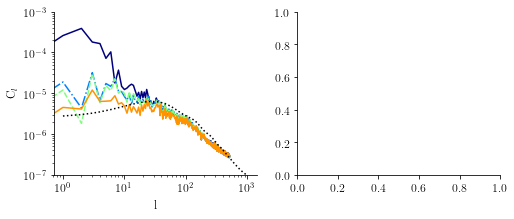

In [5]:
def plot_2dclus(config):    
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 12,
   #'text.fontsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':10
   }
    plt.rcParams.update(params)    
    cl = np.loadtxt(config['2dclustering']['cl_theory'], usecols=(1))
    ls = 5*['-','-.','--', '-']
    c  = plt.cm.jet
    Nd = len(config['2dclustering']['flb'])
    fig, ax = plt.subplots(ncols=2,figsize=(8, 3))
    #
    # C_l
    #
    for i,l in enumerate(config['2dclustering']['flb']):
        d = np.load(config['2dclustering']['clpath'](l)).item()
        #if l == 'nns':print(d['auto'][:5])
        #print(d.keys())
        ax[0].plot(np.arange(d['auto'].size), d['auto']-0.1*d['auto'][-1],
                  color=c(i/Nd), ls=ls[i]) #label=config['2dclustering']['lb'][i],
    ax[0].plot(np.arange(1, cl.size+1), 1.4**2*cl, 'k:')#, label='Theory')    
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    #ax[0].legend(frameon=False)#title = config['2dclustering']['title'])
    ax[0].set_xlabel('l')
    ax[0].set_ylabel(r'C$_{l}$')
    ax[0].set_ylim(1.e-7, 1.e-3)

    #tt, xit = np.loadtxt('/Users/rezaie/github/DESILSS/tests/lssdata/fftlog_xi.out', usecols=(0,1), unpack=True)
    #ax[1].plot(tt+0.2, xit, ':', color='k', label='Theory')


    #for i,l in enumerate(config['2dclustering']['flb']):
    #    d = np.load(config['2dclustering']['xipath'](l)).item()
    #    t = np.degrees(d['t'])[1:]    
    #    ax[1].plot(t, d['w'][0]/d['w'][1]-d['dmean']*d['dmean'], label=config['2dclustering']['lb'][i], color=c(i/Nd), ls=ls[i])

    #ax[1].legend(title = config['2dclustering']['title'], frameon=False)
    #ax[1].set_xlabel(r'$\theta [deg]$')
    #ax[1].set_ylabel(r'$\omega$')
    #ax[1].set_xlim(-0.05, 10)
    plt.savefig(config['2dclustering']['ouname'], bbox_inches='tight')
plot_2dclus(config)

['uni', 'lin', 'quad', 'nn_ab']
[5644.67804251  796.45527912  792.64283194  466.63923058]
[360. 360. 360. 360.]
[15.67966123  2.21237578  2.20178564  1.29622008]


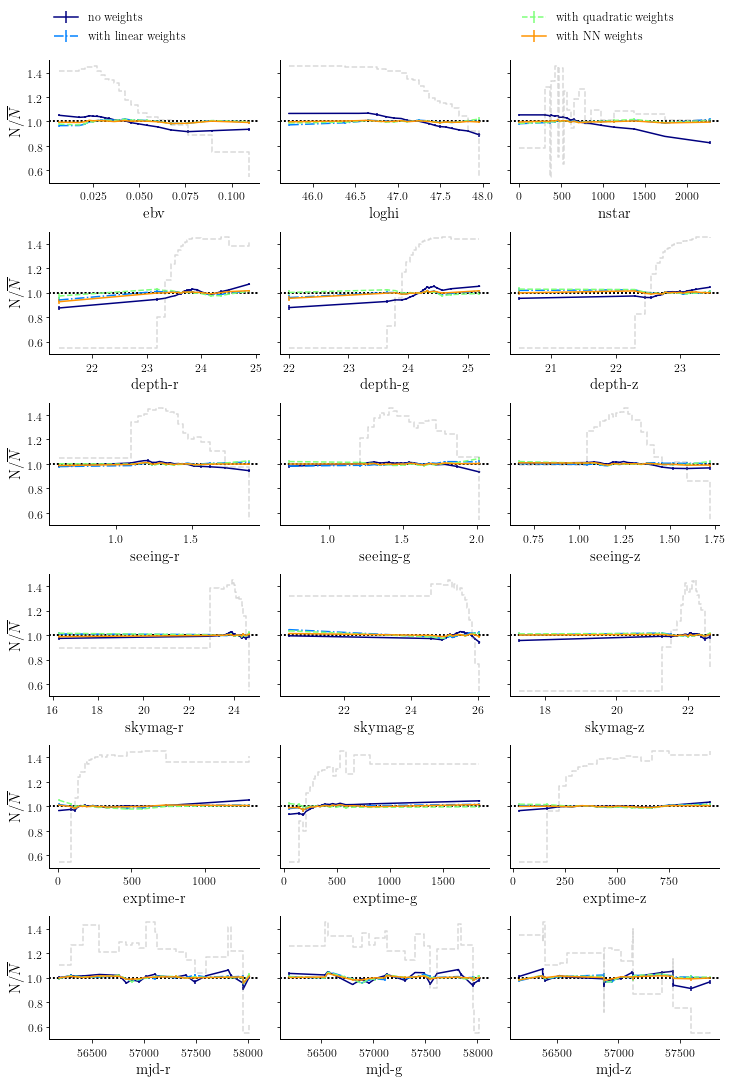

In [11]:
def plot_nnbar(config):
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 15,
   #'text.fontsize': 8,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':12
   }
    plt.rcParams.update(params)    
    lgnarg = dict(ncol=2,frameon=False,
                 bbox_to_anchor=(0, 1.1, 3, 0.4), loc="lower left",
                mode="expand", borderaxespad=0)    
    def chi2 (x, y, ye): 
        dx = np.diff(x)[2]
        m = (~np.isnan(y)) & (~np.isnan(ye) & (ye != 0.0))
        terms = (y[m]-1.0)/ye[m]
        worst = x[m][np.argmax(terms)]
        return np.sum(terms**2), m.sum()
    ls = 5*['-','-.','--', '-']
    c  = plt.cm.jet
    Nd = len(config['nnbarplot']['flb'])
    fig, ax = plt.subplots(ncols=3, nrows=6, sharey=True, figsize=(12, 18)) # 10, 16.5
    plt.subplots_adjust(wspace=0.1, hspace=0.4)
    ax = ax.flatten()
    #fig.delaxes(ax[-1])
    def add_ax(ax, res, shift=1.0, step=True, **kw):
        m = (~ np.isnan(res['nnbar'])) & (res['nnbar_err']!=0.0)
        ax.errorbar(res['bin_edges'][:-1][m]*shift, res['nnbar'][m],
                      yerr=res['nnbar_err'][m], **kw)
        ax.axhline(1, linestyle=':', color='k')
        ax2 = ax.twinx()
        ax2.set_yticks([])
        if step:ax2.step(res['bin_edges'][:-1][m], res['area'][m], where='post',
                         linestyle='--', color='grey', alpha=0.3)
    CHIS = np.zeros(Nd)
    DOFS = np.zeros(Nd)
    for i,df in enumerate(config['nnbarplot']['flb']):
        di = np.load(config['nnbarplot']['nnbarpath'](df)).item()
        for j in range(len(di['xlabels'])):
            if i ==0:
                step=True
            else:
                step=False
            add_ax(ax[j], di['nnbar'][j], color=c(i/Nd), ls=ls[i], label=config['nnbarplot']['lb'][i], step=step)
            ci2, dof = chi2(di['nnbar'][j]['bin_edges'][:-1], di['nnbar'][j]['nnbar'], di['nnbar'][j]['nnbar_err'])
            CHIS[i] += ci2
            DOFS[i] += dof
            if i==0:
                if j%3 == 0:ax[j].set_ylabel(r'N/$\overline{N}$')
                ax[j].set_xlabel(di['xlabels'][j])
                ax[j].set_ylim(0.5, 1.5)
                ax[j].locator_params(tight=True, nbins=5)
        #if i ==1:ax[i].set_xlim(xmax=6000)
    ax[0].legend(**lgnarg)
    print(config['nnbarplot']['flb'])
    print(CHIS)
    print(DOFS)
    print(CHIS/DOFS)
    plt.savefig('./figs/nnbar_dr7.pdf', bbox_inches='tight')
plot_nnbar(config)

## MOCKS

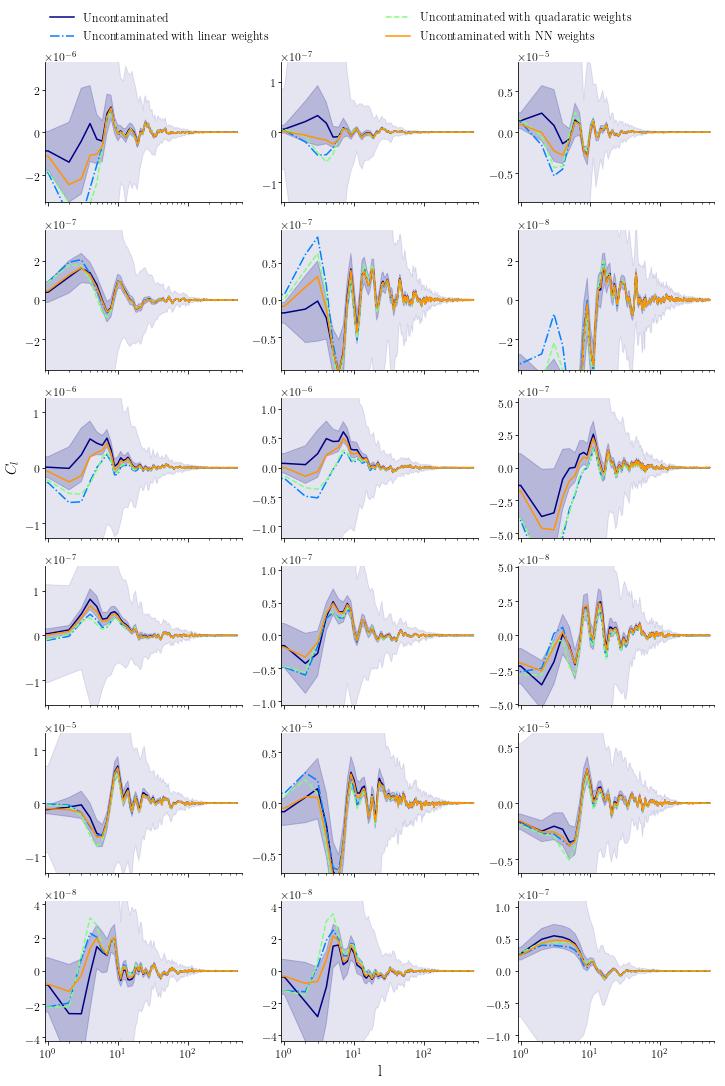

In [31]:
def plot_cl_cross_mocks():
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 15,
   #'text.fontsize': 8,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':12
   }
    plt.rcParams.update(params)    
    ls = 5*['-','-.','--', '-']
    path = '/Volumes/TimeMachine/data/mocks/3dbox/'
    #
    #  INPUTS
    u_u = glob(path  + '*/results/clustering/cl_uni.npy')
    u_l = glob(path  + '*/results/clustering/cl_lin.npy')
    u_q = glob(path  + '*/results/clustering/cl_quad.npy')
    u_nb = glob(path + '*/results/clustering/cl_nnm.npy')
    fls = [u_u, u_l, u_q, u_nb]
#           c_u, c_l, c_q, c_nb, c_f]
    lb = ['Uncontaminated', 'Uncontaminated with linear weights', 
          'Uncontaminated with quadaratic weights', 
          'Uncontaminated with NN weights']#,
#           'Contaminated', 'Contaminated with linear weights', 
#           'Contaminated with quadratic weights', 
#           'Contaminated with NN weights', 'Contaminated with linear (few maps)']
    #      'Contaminated with NN-Ablation weights']
    d = len(lb)
    syss   = ['depth', 'airmass','skymag', 'exptime', 'mjd']
    labels = ['ebv', 'loghi','nstar'] + [s+'-'+b for s in syss for b in 'rgz']
    pltarg = dict(ncols=3, nrows=6, sharex=True, figsize=(12, 18))
    tckfmt = dict(style='sci', axis='y', scilimits=(0,0))
    lgnarg = dict(ncol=2,frameon=False,
                 bbox_to_anchor=(0, 1.1, 3, 0.4), loc="lower left",
                mode="expand", borderaxespad=0) #bbox_to_anchor=(1., 1.0),
    xlim   = (.9, 600)
    ylim   = (-1.2e-7, 1.2e-7)
    #print(len(u_u), len(c_u), len(c_l), len(c_nb), len(c_nr))
    #
    #  PLOT
    #
    def add_plot(fs, a, color='b', label='none', ls='-', fill=False):    
        dall = np.zeros((18,513, 100))
        for i,fi in enumerate(fs):
            #if i%50==0:print(i)
            d = np.load(fi).item()
            dall[:,:,i] = d['cross']
        # 
        nn = np.sqrt(len(fs))
        dall_mean = np.mean(dall, axis=2)
        dall_std  = np.std(dall, axis=2)/nn
        #
        for i in range(dall.shape[0]):
            l = np.arange(dall_mean[i,:].size)
            cl= dall_mean[i,:]
            ce= dall_std[i,:]
            a[i].plot(l, cl, color=color, label=label, linestyle=ls)
            if fill:
                a[i].fill_between(l, cl-ce, cl+ce, color=color, alpha=0.2)
                a[i].fill_between(l, cl-ce*nn, cl+ce*nn, color=color, alpha=0.1)
                a[i].set_ylim(-1.5*np.max(cl+ce), 1.5*np.max(cl+ce))


    f,a    = plt.subplots(**pltarg)
    # plt.subplots_adjust(hspace=0.0, wspace=0.0)
    c = plt.cm.jet
    a = a.flatten()
    for i, fi in enumerate(fls):
        if lb[i]=='Uncontaminated':
            fill=True
        else:
            fill=False
        add_plot(fi, a, c(i/d), lb[i], ls[i], fill=fill)
    for i in range(len(a)-1):
        if i ==6:a[i].set_ylabel(r'$C_l$')
        if i ==16:a[i].set_xlabel('l')
        #if i<17:a[i].text(0.4,0.2, r'Ngal $\times$ %s'\
        #                  %labels[i], transform=a[i].transAxes)
        a[i].ticklabel_format(**tckfmt)
        a[i].tick_params(axis='y', pad=1.0)
    a[0].legend(**lgnarg)
    #f.delaxes(a[17])
    plt.xscale('log')
    plt.xlim(*xlim)
    #plt.ylim(*ylim)
    plt.savefig('./cl-cross-mock.pdf', bbox_inches='tight')
plot_cl_cross_mocks()

4 4
100


No handles with labels found to put in legend.
No handles with labels found to put in legend.


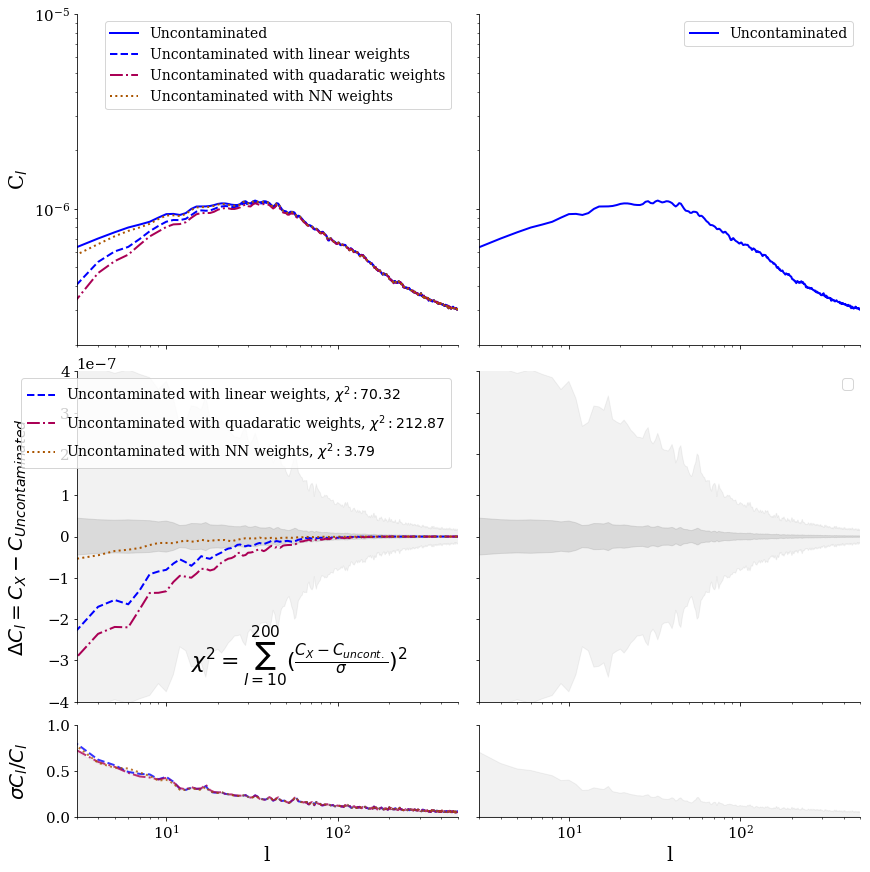

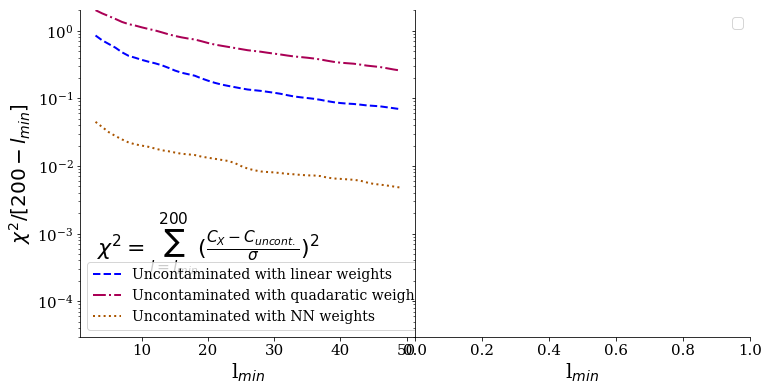

In [2]:
def plot_cl_auto_mocks():
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 20,
   #'text.fontsize': 8,
   'legend.fontsize': 14,
   'xtick.labelsize': 15,
   'ytick.labelsize': 15,
   'text.usetex': False,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
   'font.size':15
   }
    plt.rcParams.update(params)    
    path = '/Volumes/TimeMachine/data/mocks/3dbox/'
    u_u = glob(path  + '*/results/clustering-upw/cl_uni.npy')
    u_l = glob(path  + '*/results/clustering-upw/cl_lin.npy')
    u_q = glob(path  + '*/results/clustering-upw/cl_quad.npy')
    u_nb = glob(path + '*/results/clustering-upw/cl_nn.npy')
    fus = [u_u, u_l, u_q, u_nb]
#           c_u, c_l, c_q, c_nb, c_f]
    lb = ['Uncontaminated', 'Uncontaminated with linear weights', 
          'Uncontaminated with quadaratic weights', 
          'Uncontaminated with NN weights']#,
#           'Contaminated', 'Contaminated with linear weights', 
#           'Contaminated with quadratic weights', 
#           'Contaminated with NN weights', 'Contaminated with linear (few maps)']
    #      'Contaminated with NN-Ablation weights']

    print(len(fus), len(lb))
    fig = plt.figure(constrained_layout=True, figsize=(12, 12))
    gs = GridSpec(ncols=2, nrows=5, figure=fig)
    gs.update(wspace=0.0, hspace=0.0) # like subplot adjust
    ax1 = fig.add_subplot(gs[:2, 0])
    ax2 = fig.add_subplot(gs[:2, 1])
    ax3 = fig.add_subplot(gs[2:4, 0])
    ax4 = fig.add_subplot(gs[2:4, 1])
    ax5 = fig.add_subplot(gs[4, 0])
    ax6 = fig.add_subplot(gs[4, 1])
    #fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

    c       = plt.cm.brg
    ls      = 10*['-', '--', '-.', ':']
    nfls    = len(fus)-1
    cl_all  = dict()
    sigma   = dict()    
    nfiles  = len(fus[0])
    print(nfiles)
    for j,fij in enumerate(fus):
        cla = []
        for i in range(nfiles):
            fi = np.load(fij[i]).item()
            l  = np.arange(fi['auto'].size)
            cl = fi['auto']
            cla.append(cl)
        cl_all[lb[j]] = np.mean(np.array(cla), axis=0)
        sigma[lb[j]]  = np.std(np.array(cla), axis=0)/np.sqrt(len(cla))
    #    
    for a in [ax5, ax6]:
        a.fill_between(np.arange(sigma['Uncontaminated'].size),0,
                     sigma['Uncontaminated']*np.sqrt(nfiles)/cl_all['Uncontaminated'], 
                       color='grey', alpha=0.1, label=r'1$\sigma$ C.L. sample standard deviation')        
    
    for j, keyj in enumerate(cl_all.keys()):
        if keyj != 'Uncontaminated':
            dcl  = (cl_all[keyj]-cl_all['Uncontaminated'])
            chi2 = ((dcl[10:201]/sigma['Uncontaminated'][10:201])**2).sum()
            s    = sigma[keyj]/cl_all[keyj]            
            if 'Uncontaminated' in keyj:
                ax1.plot(np.arange(cl_all[keyj].size), cl_all[keyj],
                    color=c((j-1)/nfls), ls=ls[j], lw=2,
                    label=r'{:.50s}'.format(keyj))                
                ax3.plot(np.arange(cl_all[keyj].size), (dcl),
                    color=c((j-1)/nfls), ls=ls[j], lw=2,
                    label=r'{:.50s}, $\chi^{}:{:5.2f}$'.format(keyj,2, chi2))
                ax5.plot(np.arange(cl_all[keyj].size), s*10., 
                                  color=c((j-1)/nfls), alpha=0.8,lw=2,
                                   ls=ls[j])#label=r'{:.50s}'.format(keyj),
            else:
                ax2.plot(np.arange(cl_all[keyj].size), cl_all[keyj],
                    color=c((j-1)/nfls), ls=ls[j], lw=2,
                    label=r'{:.50s}'.format(keyj))                
                ax4.plot(np.arange(cl_all[keyj].size), (dcl),#/cl_all['uncont.'], 
                    color=c((j-1)/nfls), ls=ls[j], 
                    label=r'{:.50s}, $\chi^{}:{:5.2f}$'.format(keyj,2, chi2), lw=2)
                ax6.plot(np.arange(cl_all[keyj].size), s*10., 
                                  color=c((j-1)/nfls), alpha=0.8, lw=2, 
                                  ls=ls[j])                # label=r'{:.50s}'.format(keyj),
        else:
            for a in [ax1, ax2]:
                a.plot(np.arange(cl_all[keyj].size), cl_all[keyj],
                    color=c((j-1)/nfls), ls=ls[j], lw=2,
                    label=r'{:.50s}'.format(keyj))

    # ax.plot(lt, .2e6*clt, 'k-', label='theory')
    ax3.text(0.3, 0.1, r'$\chi^{2} = \sum_{l=10}^{200} (\frac{C_{X}-C_{uncont.}}{\sigma})^{2}$',
            transform=ax3.transAxes, fontsize=22)
    for a in [ax1, ax2]:
        a.set_xscale('log')
        a.set_yscale('log')
        xlim   = (3, 500)
        ylim   = (2.e-7, 1.e-5)
        a.set_xlim(*xlim)
        a.set_ylim(*ylim)
        a.legend(ncol=1)        
        
    for a in [ax3, ax4]:
        a.set_xscale('log')
        xlim   = (3, 500)
        ylim   = (-4.e-7, 4.e-7)
        a.set_xlim(*xlim)
        a.set_ylim(*ylim)
        a.legend(ncol=1, loc=1)        
        a.fill_between(np.arange(sigma['Uncontaminated'].size), -sigma['Uncontaminated'], 
                     sigma['Uncontaminated'], color='grey', alpha=0.2)
        a.fill_between(np.arange(sigma['Uncontaminated'].size), -sigma['Uncontaminated']*np.sqrt(100.),
                     sigma['Uncontaminated']*np.sqrt(100.), color='grey', alpha=0.1)
    ax1.set_ylabel(r'C$_{l}$')
    ax3.set_ylabel(r'$\Delta C_{l} = C_{X} - C_{Uncontaminated}$')#, fontsize=30)
    ax5.set_ylabel(r'$\sigma C_{l}/C_{l}$')#, fontsize=30)    
    for a in [ax5, ax6]:
        a.set_xscale('log')
        xlim   = (3, 500)
        ylim   = (0.0, 1.)
        a.set_xlim(*xlim)
        a.set_ylim(*ylim)
        a.set_xlabel('l')  
    ax3.legend()
    for a in [ax1, ax2, ax3, ax4]:
        a.set_xticklabels([])
    for a in [ax2, ax4, ax6]:
        a.set_yticklabels([])
    fig.align_labels()
#     plt.savefig('./mocks_deltacl.pdf', bbox_inches='tight')
    #
    # CHI-square plot
    #
    #
    fig, ax = plt.subplots(ncols=2, figsize=(12,6), sharey=True)
    plt.subplots_adjust(wspace=0.0)
    c  = plt.cm.brg
    ls = 10*['-', '--', '-.', ':']
    nfls=len(fus)-1
    for j, keyj in enumerate(cl_all.keys()):
        if keyj != 'Uncontaminated':
            dcl = (cl_all[keyj]-cl_all['Uncontaminated'])
            chi2l = []
            lml = np.arange(3, 50)
            for m in lml:
                chi2   = np.sum((dcl[m:201]/sigma['Uncontaminated'][m:201])**2)
                chi2l.append(chi2/(200-m))
            if 'Uncontaminated' in keyj:
                ax[0].plot(lml, chi2l, color=c((j-1)/nfls), ls=ls[j], 
                      label=r'{:.50s}'.format(keyj), lw=2)
            else:
                ax[1].plot(lml, chi2l, color=c((j-1)/nfls), ls=ls[j], 
                      label=r'{:.50s}'.format(keyj), lw=2)


    ylim   = (.3e-4, 2.)
    for i,ai in enumerate(ax):
        #ai.fill_between(lml, 1, 30, color='grey', alpha=0.1)
        #ai.set_xscale('log')
        ai.set_yscale('log')
        ai.set_ylim(*ylim)
        ai.set_xlabel(r'l$_{min}$')
        ai.legend()#bbox_to_anchor=(0.0, 0.9, 1., .102))
    ax[0].text(0.05, 0.25, r'$\chi^{2} = \sum_{l=l_{min}}^{200} (\frac{C_{X}-C_{uncont.}}{\sigma})^{2}$',
            transform=ax[0].transAxes, fontsize=22)    
    ax[0].set_ylabel(r'$\chi^{2}/[200-l_{min}]$')#, fontsize=30)
#     plt.savefig('./mocks_deltacl_chi2.pdf', bbox_inches='tight')
plot_cl_auto_mocks()

ngal E(B-V)

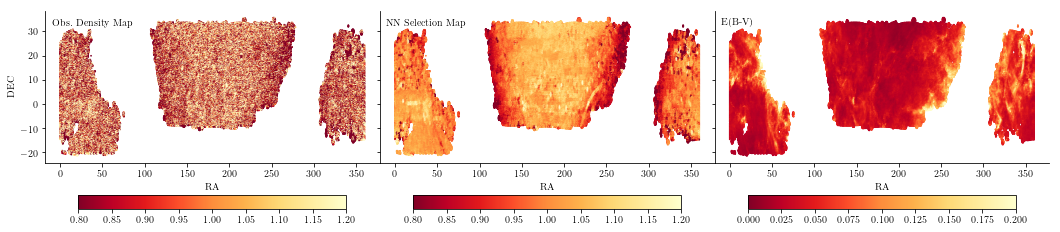

In [14]:
def ngal_ebv():    
    galmap = hp.read_map('/Volumes/TimeMachine/data/DR7/eboss-ngc-dr7.1.cut.hp256.fits', verbose=False)
    ebv = hp.read_map('/Volumes/TimeMachine/data/healSFD_256_fullsky.fits')
    wnn    = hp.read_map('/Volumes/TimeMachine/data/DR7/regression/nn/nn-r-ab-10/nn-weights.hp256.fits', verbose=False)
    wlin  = hp.read_map('/Volumes/TimeMachine/data/DR7/regression/mult-all/lin-weights.hp256.fits', verbose=False)
    wqud  = hp.read_map('/Volumes/TimeMachine/data/DR7/regression/mult-all/quad-weights.hp256.fits', verbose=False)
    mask  = hp.read_map('/Volumes/TimeMachine/data/DR7/sysmaps/DECaLS_DR7/nside256_oversamp4/mask.hp.fits', verbose=False).astype('bool')
    frac = hp.read_map('/Volumes/TimeMachine/data/DR7/sysmaps/DECaLS_DR7/nside256_oversamp4/fracgood.hp.fits', verbose=False)
    Wuni = galmap / frac *(frac[mask].sum()/galmap[mask].sum())
    Wnn  = wnn / np.mean(wnn[mask])
    Wlin = wlin / np.mean(wlin[mask])
    Wqud = wqud / np.mean(wqud[mask])
    plt.rc('axes.spines', top=False, right=False)
    plt.rc('font', family='serif')
    plt.rc('text', usetex=True)
    hpix = np.argwhere(mask).flatten()
    fig, ax = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
    plt.subplots_adjust(hspace=0.0, wspace=0.0)

    #ttl = ['No weights', 'Linear weights', 'NN weights']
    ttl = ['Obs. Density Map', 'NN Selection Map', 'E(B-V)']
    #for i,di in enumerate([duni, dlin, dnn]):
    for i,di in enumerate([Wuni, Wnn, ebv]):
        radec = hpix2radec(256, hpix)
        if i <2:
            vlims = (0.8, 1.2)
        else:
            vlims = (0.0, 0.2)
        map1 = ax[i].scatter(radec[0], radec[1], 0.5, 
                             #c=5*di[mask], vmin=-1, vmax=1.,
                            c=di[mask], vmin=vlims[0], vmax=vlims[1],
                            cmap=plt.cm.YlOrRd_r)
        fig.colorbar(map1, ax=ax[i], orientation='horizontal', shrink=0.8)
        ax[i].text(0.02, 0.9, ttl[i], transform=ax[i].transAxes)
        ax[i].set_xlabel('RA')
        ax[0].set_ylabel('DEC')
        #ax[i].axis([200, 310, 0, 20])
    # cax = plt.axes([.95, 0.1, 0.01, 0.8])
    #fig.colorbar(map1, cax=cax)
    #fig.colorbar(map1, cax=cax, label=r'$N/\overline{N}$')
    plt.savefig('./density_ebv.png', bbox_inches='tight', dpi=300)

In [52]:
cls = glob('/Volumes/TimeMachine/data/DR7_Feb10/clustering/cl_nnr*.npy')\
+ ['/Volumes/TimeMachine/data/DR7_Feb10/clustering/cl_uni.npy']

In [53]:
cls

['/Volumes/TimeMachine/data/DR7_Feb10/clustering/cl_nnr-10-smooth.npy',
 '/Volumes/TimeMachine/data/DR7_Feb10/clustering/cl_nnr-10.npy',
 '/Volumes/TimeMachine/data/DR7_Feb10/clustering/cl_nnr-ab-10-smooth.npy',
 '/Volumes/TimeMachine/data/DR7_Feb10/clustering/cl_nnr.npy',
 '/Volumes/TimeMachine/data/DR7_Feb10/clustering/cl_nnrab-10.npy',
 '/Volumes/TimeMachine/data/DR7_Feb10/clustering/cl_nnrab.npy',
 '/Volumes/TimeMachine/data/DR7_Feb10/clustering/cl_uni.npy']

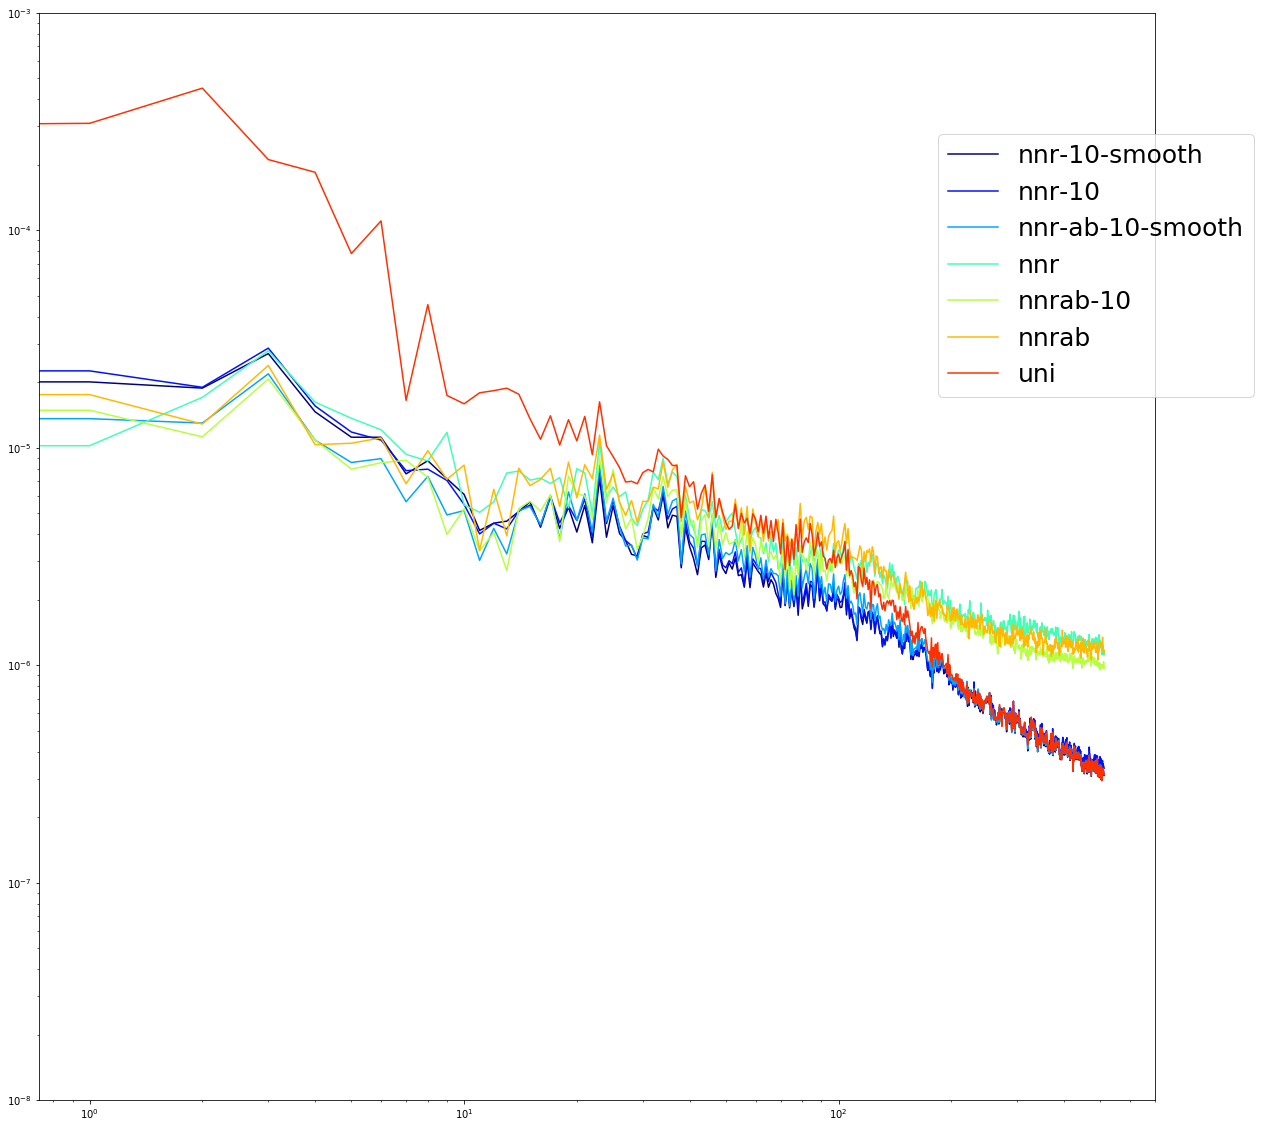

In [56]:
plt.figure(figsize=(20, 20))
c = plt.cm.jet
n = len(cls)
for i,cli in enumerate(cls):
    dc = np.load(cli).item()
    nm = cli.split('/')[-1].split('.')[0].split('_')[1]
    l  = np.arange(dc['auto'].size)
    cl = dc['auto']
    #-0.98*np.mean(dc['auto'][-5:])
    plt.plot(l, cl, label=nm, color=c(i/n))
plt.ylim(1.e-8, 1.e-3)
plt.loglog()
plt.legend(bbox_to_anchor=(1.1, 0.9), fontsize=25)

In [26]:
frac = hp.read_map('/Volumes/TimeMachine/data/DR7/sysmaps/DECaLS_DR7/nside256_oversamp4/fracgood.hp.fits')
maks = hp.read_map('/Volumes/TimeMachine/data/DR7/sysmaps/DECaLS_DR7/nside256_oversamp4/mask.hp.fits').astype('bool')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [28]:
np.sum(frac[maks]), np.mean(frac[maks])

(180332.9375, 0.9630237454407579)

In [30]:
hp.nside2pixarea(256,degrees=True)*180333./

9459.521307616584

In [61]:
cls3 = glob('/Volumes/TimeMachine/data/mocks/3dbox/001/clustering/uni/*uni.npy')
cls2 = glob('/Volumes/TimeMachine/data/mocks/3dbox/001/cablin/clustering/uni/*uni.npy')
cls = glob('/Volumes/TimeMachine/data/mocks/3dbox/001/cablin/clustering/nn-ab-smooth/*nn.npy')
#cls

(1e-08, 0.0002)

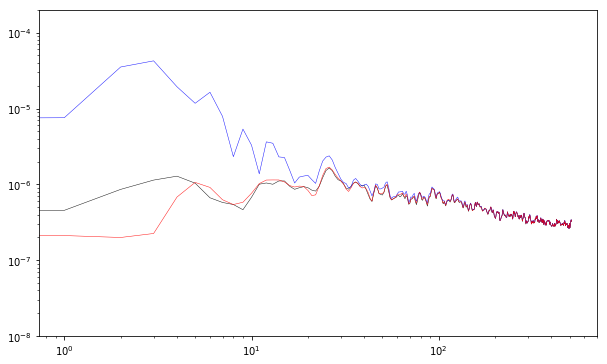

In [63]:
plt.figure(figsize=(10, 6))
i = 0
c = ['black', 'blue', 'red']
for cl_i in [cls3, cls2, cls]:
    for cl in cl_i:
        d = np.load(cl).item()
        L = np.arange(d['auto'].size)
        Cl= d['auto']
        plt.loglog(L, Cl, color=c[i], alpha=0.9, lw=0.5)
    i += 1
plt.ylim(1.e-8, 2.e-4)
# plt.legend()

In [30]:
lists   = glob('/Volumes/TimeMachine/data/mocks/3dbox/001/regressiondr5/n*/regression/nn-ab/nn-log.txt')
idlists = [int(listi.split('/')[6]) for listi in lists]
idlists

In [6]:
m = hp.read_map('/Volumes/TimeMachine/data/mocks/mock.hpmask.dr7.fits').astype('bool')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


0 1.0 1.0 0
0 1.0 1.0 0
1 1.0 1.0 0
1 1.0 1.0 0
2 1.0 1.0 0
2 1.0 1.0 0
3 6.697559833526611 7.965914249420166 0
3 5.649767875671387 8.053679466247559 0
4 1.0 1.0 0
4 1.0 1.0 0
5 1.0 1.0 0
5 1.0 1.0 0
6 6.188497066497803 8.084966659545898 0
6 6.1689629554748535 8.695767402648926 0
7 1.0 1.0 0
7 1.0 1.0 0
8 6.48145866394043 7.0180745124816895 0
8 6.195014476776123 7.02951717376709 0
9 1.0 1.0 0
9 1.0 1.0 0
10 6.726716041564941 7.302966594696045 0
10 6.673151016235352 7.292779445648193 0
11 1.0 1.0 0
11 1.0 1.0 0
12 1.0 1.0 0
12 1.0 1.0 0
13 1.0 1.0 0
13 1.0 1.0 0
14 1.0 1.0 0
14 1.0 1.0 0
15 1.0 1.0 0
15 1.0 1.0 0
16 6.344825744628906 7.98176908493042 0
16 4.2022013664245605 8.491073608398438 0
17 6.238766670227051 9.178970336914062 0
17 5.583316802978516 9.595497131347656 0
18 6.671456813812256 7.155736923217773 0
18 6.209018230438232 6.982179641723633 0
19 6.7050395011901855 8.604063034057617 0
19 6.66030216217041 8.420848846435547 0
20 1.0 1.0 0
20 1.0 1.0 0
21 1.0 1.0 0
21 1.0 1.0 0


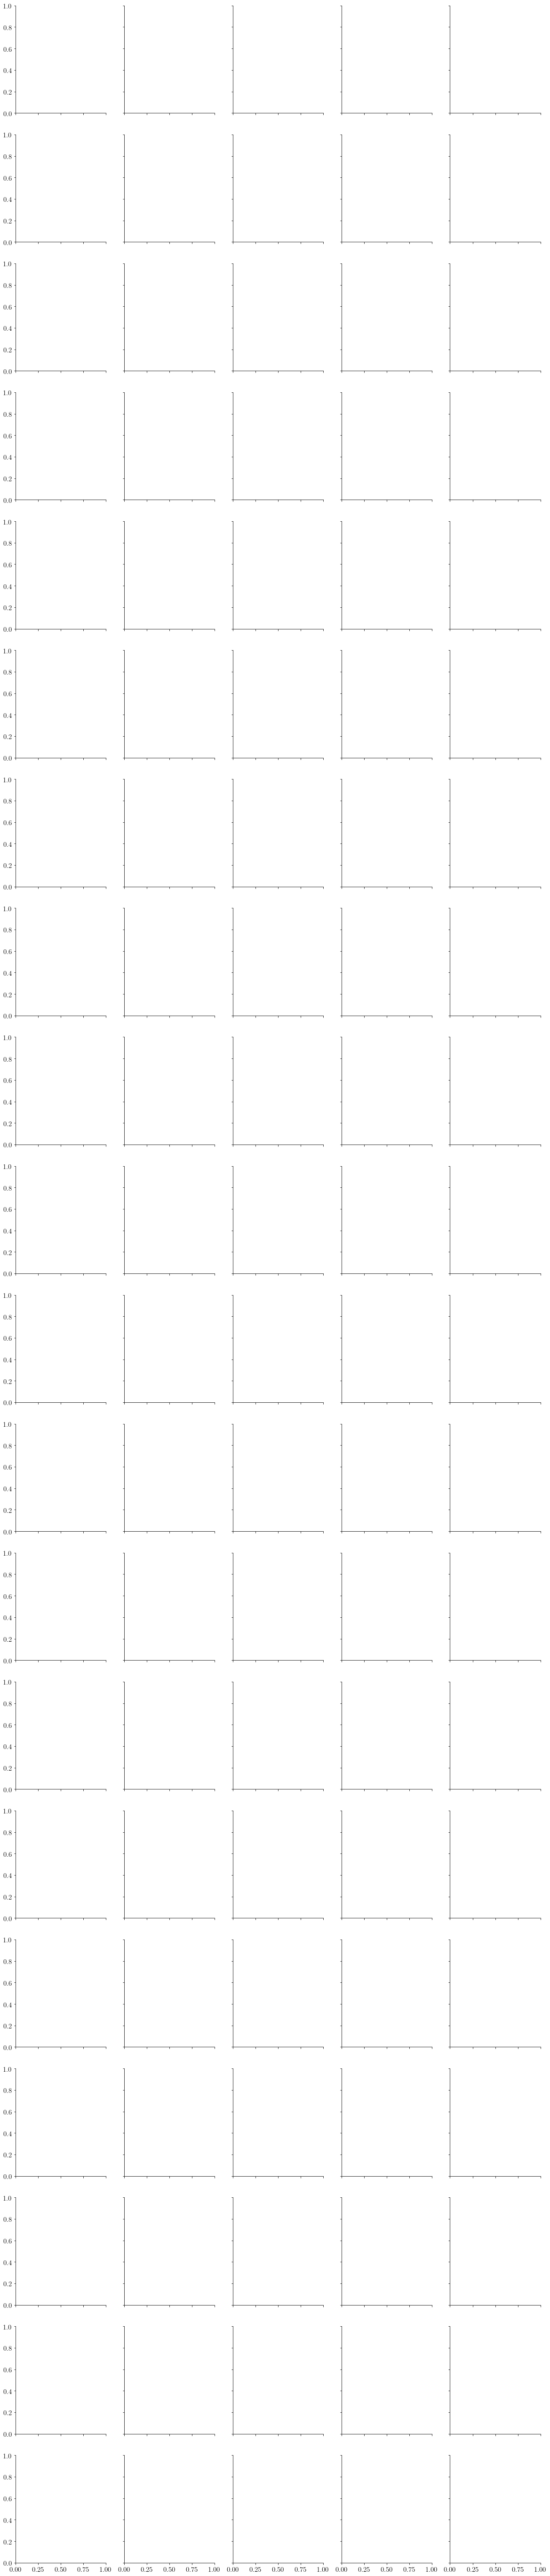

In [67]:
fig, ax = plt.subplots(ncols=5, nrows=20, figsize=(20, 100), sharey=True, sharex=True)
ax = ax.flatten()
for i in range(100):    
    path = '/Volumes/TimeMachine/data/mocks/3dbox/{:03}/'.format(i+1)
    d1  = hp.read_map(path+'regression/nn-ab-1/nn-weights.hp256.fits', verbose=False)
    d   =  hp.read_map(path+'regression/nn-ab/nn-weights.hp256.fits', verbose=False)
    for di in [d, d1]:
        print(i, di[m].min(), di[m].max(), (di[m]<0.0).sum())
#         ax[i].hist(di[m], alpha=0.5, range=(-2, 12), bins=50)
#         ax[i].set_yscale('log')

In [100]:
Cl = [[], []]
for i in range(100):
    path = '/Volumes/TimeMachine/data/mocks/3dbox/{:03}/'.format(i+1)
    if i == 91:
        print(path)
        cle = np.load(path + 'clustering/nn-ab-smooth/cl_nn.npy').item()
        continue
    if i % 20 ==0:print(i)
    d = np.load(path + 'clustering/nn-ab-smooth/cl_nn.npy').item()
    if i in idlists:
        Cl[0].append(d['auto'])
    else:
        Cl[1].append(d['auto'])

0
20
40
60
80
/Volumes/TimeMachine/data/mocks/3dbox/092/


(100, 600)

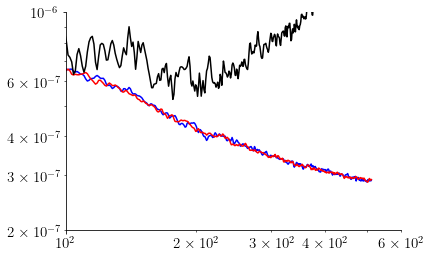

In [103]:
i = 0
c = ['blue', 'red']
l = np.arange(513)
for cli in Cl:
    clm = np.mean(np.array(cli), axis=0)
    plt.loglog(l, clm, color=c[i])
    i += 1
plt.loglog(l, cle['auto'], 'k')
plt.ylim(2.e-7, 1.e-6)
plt.xlim(100, 600)

In [122]:
hpn = ft.read('/Volumes/TimeMachine/data/DR7_Feb10/regression/nn/nn-r-ab/nn-weights256.fits')

In [127]:
(hpn['weight']==0.0).sum()

0

In [125]:
nw = ft.read('/Volumes/TimeMachine/data/mocks/3dbox/092/regression/nn-ab-1/nn-weights256.fits')

In [126]:
nw['weight'].min()

5.030480582151553

In [104]:
d = np.load('/Volumes/TimeMachine/data/mocks/3dbox/092/092.hp.256.5.r.npy').item()

In [107]:
frac = hp.read_map('/Volumes/TimeMachine/data/DR7_Feb10/sysmaps/DECaLS_DR7/nside256_oversamp4/fracgood.hp.fits')
mask = hp.read_map('/Volumes/TimeMachine/data/DR7_Feb10/sysmaps/DECaLS_DR7/nside256_oversamp4/mask.hp.fits').astype('bool')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [110]:
frac[mask].min()


0.25

In [5]:
linw = hp.read_map('/Volumes/TimeMachine/data/DR7/regression/mult-all/lin-weights.hp256.fits')
nww = ft.read('/Volumes/TimeMachine/data/DR7/regression/nn/nn-r-ab-10/nn-weights256.fits')
np.min(nww['weight']), np.max(nww['weight'])

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


(-11.729593830470275, 99.46693748683418)

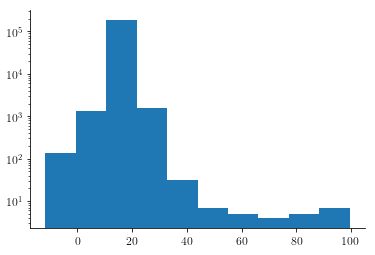

In [142]:
plt.hist(nww['weight'])
# plt.hist(linw[nww['hpix']])
plt.yscale('log')

In [7]:
np.std(nww['weight'])

2.0815786706771666

In [13]:
thph = hp.pix2ang(256, nww['hpix'])

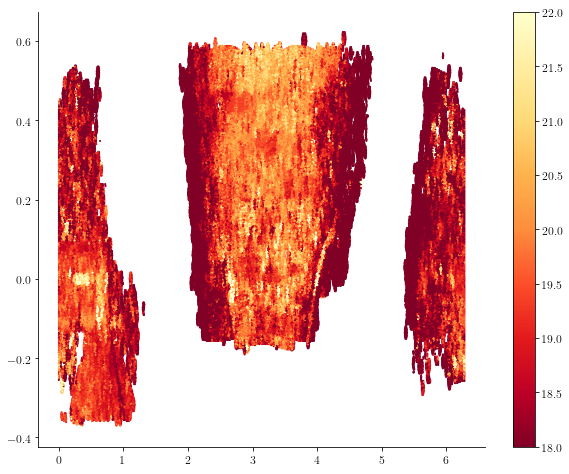

In [21]:
plt.figure(figsize=(10, 8))
plt.scatter(thph[1], np.pi/2-thph[0], 1., c=nww['weight'], vmin=18, vmax=22, cmap=plt.cm.YlOrRd_r)
plt.colorbar()